# This notebook contains functions (with examples) for calculating emittance from quadrupole beam size scans

# This function produces unconstrained (not physically validated) parabolic fits to batched measurement scans

In [1]:
import torch

def compute_emits_from_batched_beamsize_scans(k, y_batch, q_len, distance):
    '''    
    k: 1d torch tensor of shape (n_steps_quad_scan,)
    representing the measurement quad geometric focusing strengths in [m^-2]
    used in the emittance scan

    y_batch: 2d torch tensor of shape (n_scans x n_steps_quad_scan),
    where each row represents the beamsize squared outputs in [m^2] of an emittance scan
    with inputs given by k

    q_len: float defining the (longitudinal) quadrupole length or "thickness" in [m]
    
    distance: the longitudinal distance (drift length) in [m] from the measurement 
    quadrupole to the observation screen
    
    NOTE: every measurement scan is assumed to have been evaluated
    at the single set of measurement param inputs described by k

    NOTE: geometric configuration for LCLS OTR2 emittance/quad measurement scan
        q_len = 0.108  # measurement quad thickness
        distance = 2.26  # drift length from measurement quad to observation screen
    '''

    device = k.device

    k = k.reshape(-1, 1)
    x_fit = k * distance * q_len

    # least squares method to calculate parabola coefficients
    A_block = torch.cat(
        (
            x_fit**2,
            x_fit,
            torch.tensor([1], device=device)
            .repeat(len(x_fit))
            .reshape(x_fit.shape),
        ),
        dim=1,
    )
    B = y_batch.double()

    abc = A_block.pinverse().repeat(*y_batch.shape[:-1], 1, 1).double() @ B.reshape(
        *B.shape, 1
    )
    abc = abc.reshape(*abc.shape[:-1])
    is_valid = torch.logical_and(
        abc[:, 0] > 0, (abc[:, 2] > abc[:, 1] ** 2 / (4.0 * abc[:, 0]))
    )

    # analytically calculate the Sigma (beam) matrices from parabola coefficients
    # (non-physical results are possible)
    M = torch.tensor(
        [
            [1, 0, 0],
            [-1 / distance, 1 / (2 * distance), 0],
            [1 / (distance**2), -1 / (distance**2), 1 / (distance**2)],
        ],
        device=device,
    )

    sig = torch.matmul(
        M.repeat(*abc.shape[:-1], 1, 1).double(),
        abc.reshape(*abc.shape[:-1], 3, 1).double(),
    )  # column vectors of sig11, sig12, sig22

    sigma = (
        sig.reshape(-1, 3)
        .repeat_interleave(torch.tensor([1, 2, 1], device=device), dim=1)
        .reshape(*sig.shape[:-2], 2, 2)
    )  # 2x2 sigma/covar beam matrix

    # compute emittances from sigma (beam) matrices
    emit_squared = torch.linalg.det(sigma)

    emit = torch.sqrt(
        emit_squared
    )  # these are the emittances for every tuning parameter combination.

    emit_squared = emit_squared.reshape(y_batch.shape[0], -1)
    emit = emit.reshape(y_batch.shape[0], -1)

    abc_k_space = torch.cat((abc[:,0].reshape(-1,1)*(distance*q_len)**2, 
                             abc[:,1].reshape(-1,1)*(distance*q_len), 
                             abc[:,2].reshape(-1,1)), 
                            dim=1)
    
    return emit, emit_squared, is_valid, abc_k_space, sigma

#  Here are 2 options for computing emittance using above function

# Option 1: 
## Calculate emittance via unconstrained (not physically validated) parabolic fit

In [2]:
def compute_emit_from_single_beamsize_scan_numpy(k, y, q_len, distance, visualize=False, tkwargs=None):
    '''
    Parameters:
    
        k: 1d numpy array of shape (n_steps_quad_scan,)
        representing the measurement quad geometric focusing strengths in [m^-2]
        used in the emittance scan

        y_batch: 1d numpy array of shape (n_steps_quad_scan, )
        representing the beamsize outputs in [m] of an emittance scan
        with inputs given by k

        q_len: float defining the (longitudinal) quadrupole length or "thickness" in [m]

        distance: the longitudinal distance (drift length) in [m] from the measurement 
        quadrupole to the observation screen
    
    Returns:
        
        emit: the computed emittance from a simple parabolic fit to each measurement scan
        (can be NaN if the parabolic fit is not physical)
        
        emit_squared: the computed emittance squared from parabolic fitting (can be negative
        if the fit is not physical)
        
        
    NOTE: every measurement scan is assumed to have been evaluated
    at the single set of measurement param inputs described by k

    NOTE: geometric configuration for LCLS OTR2 emittance/quad measurement scan
        q_len = 0.108  # measurement quad thickness
        distance = 2.26  # drift length from measurement quad to observation screen
    '''
    if tkwargs is None:
        tkwargs = {"dtype": torch.double, "device": "cpu"}
        
    k = torch.tensor(k, **tkwargs)
    y = torch.tensor(y, **tkwargs)
    
    (emit, 
     emit_squared, 
     is_valid, 
     abc, 
     sigma) = compute_emits_from_batched_beamsize_scans(
                                                    k,
                                                    y.pow(2).reshape(1,-1),
                                                    q_len,
                                                    distance
                                                    )
    
    if visualize:
        k_fit = torch.linspace(k.min(), k.max(), 10, **tkwargs)
        bss_fit = abc @ torch.cat((k_fit.pow(2).reshape(1,-1),
                                   k_fit.pow(1).reshape(1,-1),
                                   torch.ones_like(k_fit).reshape(1,-1)),
                                   dim=0
                                   )
        
        from matplotlib import pyplot as plt
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        fit, = plt.plot(k_fit.detach().numpy(), 
                        bss_fit.flatten(), 
                        label='Fit', 
                        zorder=1)
        obs = plt.scatter(k,
                          y.pow(2),
                          marker='x',
                          s=120,
                          c='orange',
                          label='Measurements',
                          zorder=2)
        plt.title('Unconstrained (non-validated) Emittance Measurement Scan Fit')
        plt.xlabel('Measurement Quad Geometric Focusing Strength (k)')
        plt.ylabel('Beam Size Squared')
        plt.legend(handles=[obs, fit])
        plt.show()
        plt.close()
        
        
    return (
            emit.detach().numpy(),
            emit_squared.detach().numpy(),
            is_valid.detach().numpy(),
            abc.detach().numpy(),
            sigma.detach().numpy()
           )

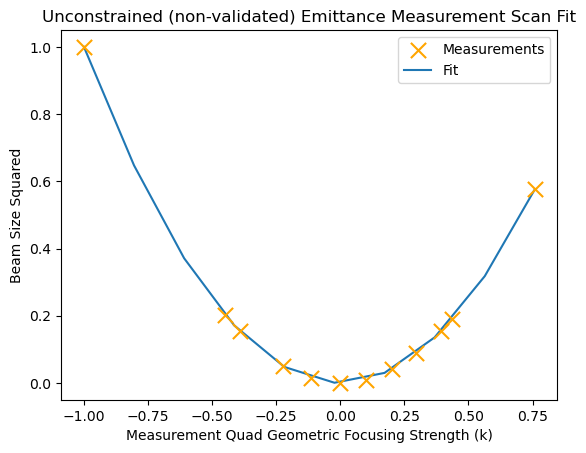

(array([[nan]]),
 array([[-1.7265393e-06]]),
 array([False]),
 array([[ 1.00000000e+00,  0.00000000e+00, -2.77555756e-16]]),
 array([[[16.78555134, -7.4272352 ],
         [-7.4272352 ,  3.2863872 ]]]))

In [3]:
import numpy as np
k_meas = np.array([0.000000,
                    0.100000,
                    -1.000000,
                    -0.392787,
                    0.297180,
                    0.759159,
                    -0.223823,
                    0.394187,
                    -0.450012,
                    -0.115379,
                    0.200063,
                    0.436399])

rms_beam_size = np.array([0.000000,
                       0.100000,
                       1.000000,
                       0.392787,
                       0.297180,
                       0.759159,
                       0.223823,
                       0.394187,
                       0.450012,
                       0.115379,
                       0.200063,
                       0.436399 ])

compute_emit_from_single_beamsize_scan_numpy(k_meas, rms_beam_size, q_len=.108, distance=2.26, visualize=True)

# Option 2: 
## Fit bayesian model to scan values, 
## evaluate virtual measurement scans using model posterior samples,
## get unconstrained (not physically validated) parabolic fits from virtual scan values, 
## validate (reject unphysical) results

In [4]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch import fit_gpytorch_mll
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors import GammaPrior
from gpytorch import ExactMarginalLogLikelihood

def get_valid_emit_samples_from_quad_scan(k, y, q_len, distance, 
                                          n_samples=10000, 
                                          n_steps_quad_scan=10, 
                                          visualize=False, 
                                          tkwargs=None):   
    if tkwargs is None:
        tkwargs = {"dtype": torch.double, "device": "cpu"}

    k = torch.tensor(k, **tkwargs)
    y = torch.tensor(y, **tkwargs)
    
    covar_module = ScaleKernel(MaternKernel(),
                                   outputscale_prior=GammaPrior(2.0, 0.15))
#     covar_module = ScaleKernel(PolynomialKernel(power=2),
#                                outputscale_prior=GammaPrior(2.0, 0.15))        
    model = SingleTaskGP(k.reshape(-1,1),
                        y.pow(2).reshape(-1,1),
                        covar_module=covar_module,
                        input_transform=Normalize(1),
                        outcome_transform=Standardize(1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
        
    k_virtual = torch.linspace(k.min(), k.max(), n_steps_quad_scan, **tkwargs)

    p = model.posterior(k_virtual.reshape(-1,1))
    bss = p.sample(torch.Size([n_samples])).reshape(-1, n_steps_quad_scan)

    (
        emits,
        emits_sq,
        is_valid,
        abc_k_space,
        sigmas_all
    ) = compute_emits_from_batched_beamsize_scans(k_virtual, bss, q_len, distance)
    sample_validity_rate = (torch.sum(is_valid) / is_valid.shape[0]).reshape(1)

    cut_ids = torch.tensor(range(emits_sq.shape[0]))[is_valid]
    emits_sq_valid = torch.index_select(
        emits_sq, dim=0, index=cut_ids
    )
    emits_valid = emits_sq_valid.sqrt()
    

    if visualize:
        #only designed for beam size squared models with 1d input
        abc_valid = torch.index_select(
            abc_k_space, dim=0, index=cut_ids
        )
        bss_fits_valid = abc_valid @ torch.cat((k_virtual.pow(2).reshape(1,-1),
                                   k_virtual.pow(1).reshape(1,-1),
                                   torch.ones_like(k_virtual).reshape(1,-1)),
                                   dim=0
                                   )
        upper_quant = torch.quantile(bss_fits_valid, q=0.975, dim=0)
        lower_quant = torch.quantile(bss_fits_valid, q=0.025, dim=0)
        
        from matplotlib import pyplot as plt
        import os
        os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
        fit = plt.fill_between(k_virtual, 
                               lower_quant, 
                               upper_quant, 
                               alpha=0.3, 
                               label='\"Bayesian\" Fit', 
                               zorder=1)
        obs = plt.scatter(k,
                          y.pow(2),
                          marker='x',
                          s=120,
                          c='orange',
                          label='Measurements',
                          zorder=2)
        plt.title('Validated Emittance Measurement Scan Fits')
        plt.xlabel('Measurement Quad Geometric Focusing Strength (k)')
        plt.ylabel('Beam Size Squared')
        plt.legend(handles=[obs, fit])
        plt.show()
        plt.close()
        
    return emits_valid, emits_sq, is_valid, sample_validity_rate, sigmas_all

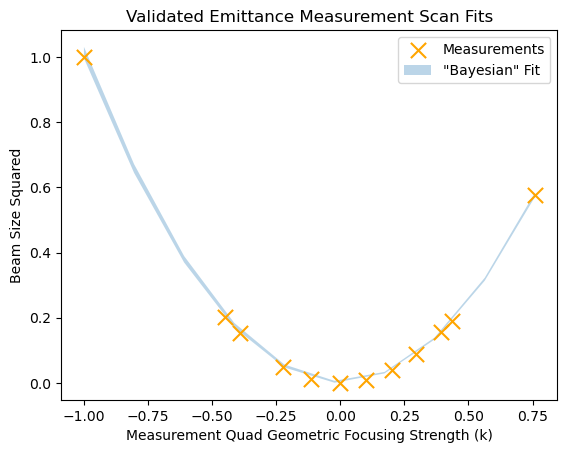

Bayesian emittance calc took 0.344 seconds.


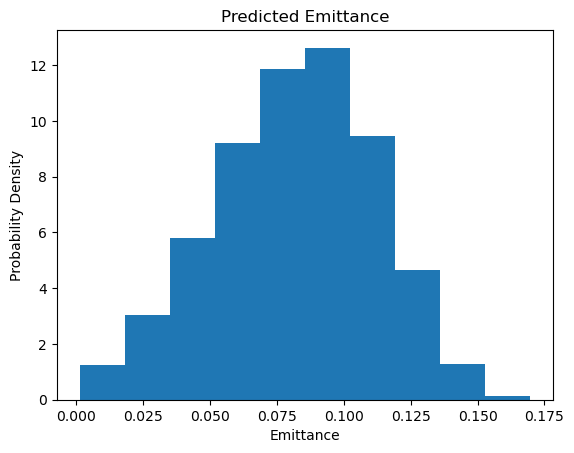

In [5]:
import time

start = time.time()

(emits_valid, 
 emits_sq, 
 is_valid, 
 sample_validity_rate, 
 sigmas_all) = get_valid_emit_samples_from_quad_scan(k_meas, 
                                                     rms_beam_size, 
                                                     q_len=.108, 
                                                     distance=2.26, 
                                                     n_samples=10000, 
                                                     visualize=True)

end = time.time()

from matplotlib import pyplot as plt
plt.hist(emits_valid.flatten(), density=True)
plt.title('Predicted Emittance')
plt.xlabel('Emittance')
plt.ylabel('Probability Density')
print('Bayesian emittance calc took', round(end-start, 3) ,'seconds.')
